# STATISTICS Applied to data science

## Exercises PART 2: Inferential statistics, effect sizes and power tests


<img align="center" width="800"  src="../images/inferential.png">


In [1]:
import numpy as np
from numpy import random
import pandas as pd
from numpy.random import seed, randn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)
#%matplotlib inline

from scipy import stats
from scipy.stats import t, norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats import power
from scipy.stats import shapiro

# jupyter lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# precision options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%precision 4
np.set_printoptions(precision=4, suppress=True)

import warnings
warnings.filterwarnings('ignore')

# Hypothesis testing with inferential statistics

Write your own t-test for two independent samples and calculate the p-value of the statistic.  

>The corresponding p-value of the **calculated t statistic** can be obtained using the cumulative distribution function of the **t-distribution** (look at `stats.t.cdf(t_calc, df)`, where t_calc is the statistic, and df is the degrees of freedom, which is the number of observations -1).

The critical value of `t` for a given alpha and degrees of freedom can be obtained using for example `stats.t.ppf(0.95,df=10)`

![Image](../images/ttest.jpg)

In [2]:
def a_ttest(a, b):
    # 
    #
    #
    #
    #
    return t, p_value

### Finding the `t-critical`, or the threshold 

What is the t-critical for a sample size of 10, and alpha of 95%?

In [3]:
stats.t.ppf(0.95, df=10)

1.8125

**See if you find a similar probability, for this t-critical:**

In [4]:
stats.t.cdf(1.3721836411102863, df=10)

0.9000

Other examples:
What is the t-critical for a sample size of 50 and alpha of 95%?

In [5]:
stats.t.ppf(0.95, df=50)

1.6759

Observe that the critical t-value changes depending on the sample size. The logic is that, the samller the sample size, the larger the difference between means needs to be, to be considered as significant.    
What is the t-critical for a sample size of 5 and alpha of 95%?

In [6]:
stats.t.ppf(0.95, df=5)

2.0150

In [7]:
stats.t.pdf(0.95, df=5)

0.2307

### Finding the probability associated with the `t-value` you calculated using the formula above  

For example, if the t statistic of your test is 1.6, and you had 10 samples:

In [8]:
1-stats.t.cdf(1.6, df=9)

0.0720

# Simple hypothesis test - Comparing two samples

In [9]:
sales = pd.read_csv('../../timeseries predictive modelling/datasets/rossman_train.csv')
stores = pd.read_csv('../../timeseries predictive modelling/datasets/rossman_store.csv')

# join store features into the sales df
sales = pd.merge(sales, stores, on='Store', how='left')

In [10]:
len(sales)

1017209

In [11]:
sales.groupby([ 'Assortment'])['Store'].nunique().reset_index()

,Assortment,Store
0,a,593
1,b,9
2,c,513


In [12]:
sales_store_a = sales[(sales.Assortment=='a')&(sales.Open==1)&(sales.Sales>0)].Sales.head(15)
sales_store_c = sales[(sales.Assortment=='c')&(sales.Open==1)&(sales.Sales>0)].Sales.head(15)

In [13]:
sales_store_a

0      5263
1      6064
2      8314
4      4822
5      5651
7      8492
9      7185
12     8821
13     6544
16     8430
19     9593
21     6566
22     7273
24    14180
25     7818
Name: Sales, dtype: int64

In [14]:
sales_store_c

3     13995
6     15344
8      8565
10    10457
11     8959
14     9191
15    10231
17    10071
18     8234
20     9515
23    14190
28     9411
30     7248
32    10789
34    12412
Name: Sales, dtype: int64

In [15]:
sales_store_a.describe().transpose()
sales_store_c.describe().transpose()

count      15.00
mean     7667.73
std      2276.16
min      4822.00
25%      6304.00
50%      7273.00
75%      8461.00
max     14180.00
Name: Sales, dtype: float64

count      15.00
mean    10574.13
std      2374.11
min      7248.00
25%      9075.00
50%     10071.00
75%     11600.50
max     15344.00
Name: Sales, dtype: float64

### With a T-test, compare these 15 samples of Store A and Store C

In [16]:
stats.ttest_ind(sales_store_a, sales_store_c, equal_var = False)

Ttest_indResult(statistic=-3.42248872836309, pvalue=0.001930415910116486)

**The above `statistic` was obtained using the formula above (aka `t-calc`, and the `pvalue` was obtained using the cumulative distribution function of the T statistic**. You can check doing this:

In [17]:
stats.t.cdf(0, df=5)

0.5000

In [18]:
stats.t.cdf(-3.42248872836309, df=14)

0.0021

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

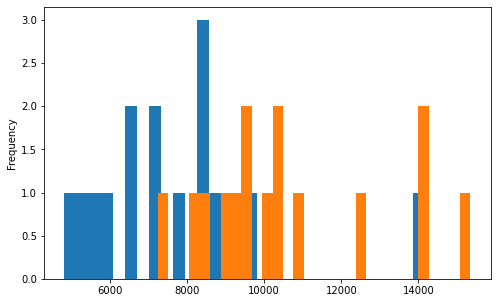

In [19]:
sales_store_a.plot.hist(bins=30)
sales_store_c.plot.hist(bins=30)

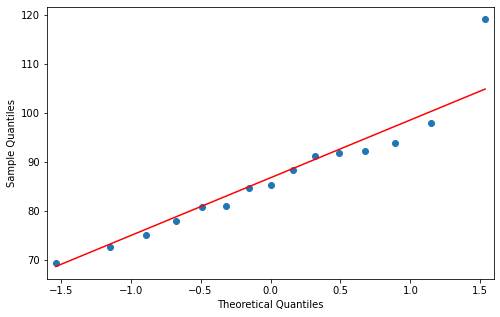

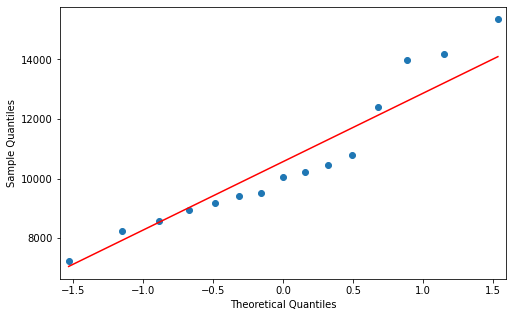

In [20]:
r = qqplot(np.sqrt(sales_store_a), line='s')
r = qqplot(sales_store_c, line='s')

---

# Hypothesis testing in linear models  

In linear models, given generically as `y = a + bx`, we are testing two hypothesis.  

* In a OLS model (ordinary-least-squares) we are trying to find a model that **minimizes significantly** the variance in the data, compared to the simplest model (**the mean**).
* The `p-value` associated with the F-test statistic is the probability of finding an R-squared as big or bigger, given that the null hypothesis is true; 
* The second hypothesis is that the intercept (or constant) **a** and/or the feature coefficients (like **b**) are statistically different from zero.  

Let's load some data and try out:   

In [21]:
# Load Boston house prices data
from sklearn.datasets import load_boston
dt = load_boston(return_X_y=False)
df = pd.DataFrame(data = np.c_[dt['data'],dt['target']])
df.columns = np.append(dt['feature_names'], 'MED_VALUE')
df.drop(['B', 'LSTAT'], inplace=True, axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MED_VALUE
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,36.20


### **Influcence of landscape and demography in house prices in Boston**  

**TARGET**  
`MEDV` Median value of owner-occupied homes in thousands

**POSSIBLE FACTORS**  
`CRIM` per capita crime rate by town    
`NOX` nitric oxides concentration (parts per 10 million)   
`RM` average number of rooms per dwelling    
`DIS` weighted distances to five Boston employment centres     
`RAD` index of accessibility to radial highways    
`TAX` full-value property-tax rate per $10,000     
`PTRATIO` pupil-teacher ratio by town    

In [22]:
import statsmodels.api as sm
X = sm.add_constant(df[['CRIM', 'ZN', 'INDUS']], prepend=False)
y = df['MED_VALUE']

# Fit and summarize OLS model
mod = sm.OLS(y, X).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:              MED_VALUE   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     69.59
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           1.21e-37
Time:                        21:09:40   Log-Likelihood:                -1752.3
No. Observations:                 506   AIC:                             3513.
Df Residuals:                     502   BIC:                             3529.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.2486      0.044     -5.662      0.0

In [23]:
import statsmodels.api as sm
X = sm.add_constant(df[['CRIM',  'INDUS']], prepend=False)
y = df['MED_VALUE']

# Fit and summarize OLS model
mod = sm.OLS(y, X).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:              MED_VALUE   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     96.83
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           2.66e-36
Time:                        21:09:40   Log-Likelihood:                -1757.8
No. Observations:                 506   AIC:                             3522.
Df Residuals:                     503   BIC:                             3534.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.2455      0.044     -5.536      0.0

---

### There's a `p-value` associated with the F-test statistic. What does it mean? What is the null hypothesis being tested here? 

### There's a `p-value` associated with every coefficient in the model. What does it mean? What is the null hypothesis here?

---

# Effect sizes and Power tests  

![Image](../images/power.png)

Results of inference tests can be statistically significant but trivial (for example, 

Commom measures of the **size of an effect** are:
* The diference between samples expressed in a standardized way
* Correlation coefficients
* R-square: 

### Cohens's D as a measure of effect size

In [24]:
from numpy.random import randn
from numpy.random import seed
 
def cohen_d(d1, d2):
    """Calculate Cohen's d for two independent samples"""
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples - Which variance (biased or unbiased) is being used here?
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [25]:
 # seed random number generator
seed(3)
# prepare data
sample1 = 10 * randn(100) + 105
sample2 = 10 * randn(100) + 100
# calculate cohen's d
d = cohen_d(sample1, sample2)
print('Mean of sample 1: %.3f' % np.mean(sample1), '| Mean of sample 2: %.3f' % np.mean(sample2))
print('The observed effect size is (= difference):', np.mean(sample1)- np.mean(sample2))
print('the standardized effect size is (Cohens d): %.3f' % d)

Mean of sample 1: 103.914 | Mean of sample 2: 99.671
The observed effect size is (= difference): 4.243071213076419
the standardized effect size is (Cohens d): 0.433


# POWER tests and data science
## Using power tests to design A/B tests

**With the library `statsmodels` use this method for a 2-sample test**

<code>
from statsmodels.stats import power  
power.tt_ind_solve_power(effect_size=None, nobs1=None, alpha=None, power=None, ratio=1.0, alternative='two-sided')  </code> 


* You can solve for one of the desired parameters `effect_size`, `nobs1`, `alpha`, or `power`, and you have to provide a value for the other 3.

Here `effect size` means the standardized effect size, i. e., the diference between the two means divided by the standard deviation.   
> An standardized effect size of 1 means that the average of one model is 1 standard deviation greater/lower than the average of the other. In other words, if RMSE of model A is 70, and the pooled standard deviation is 10, the RMSE of model B must be 80.


## A/B test example
![Image](../images/abtesting.png)  
I have two models predicting the daily demand of the top-seller product. One is a Random forest and the other one, new, is a XGBoost.  
Before replacing the old model, which is currently in production, I need to show my team that the new model is (statistically) **significantly better** than the old model.  
### How would you plan this A/B test?  


Suppose you compared the performance of two models during 20 days (`nobs1`=40 because there's 2 models).

What is the number of samples `nobs1` required to detect an effect size of 1, given alpha=0.05 and power of 0.8?

In [26]:
"the number of required samples is"
power.tt_ind_solve_power(effect_size=1, nobs1=None, alpha=0.05, power=0.80, ratio=1.0, alternative='two-sided')

'the number of required samples is'

16.7147

How to interpret the number above?  
it means that, if the effect size is 1, you would have neeed only 16 observations to detect the effect 🎉🎉

However, the test above considered a two-sided test, meaning the "new" model could be either 1 standard deviation better or worse than the current model. 

In [27]:
power.tt_ind_solve_power(effect_size=1, nobs1=None, alpha=0.05, power=0.80, ratio=1.0, alternative='larger')

13.0978

Now, your manager says you only have 10 days to test your model before making a decision.  
What would be the minimum effect size that you can detect with 80% power?

In [ ]:
"The minimum effect size possible to detect in 10 days is"
power.tt_ind_solve_power(effect_size=None, nobs1=100, alpha=0.05, power=0.8, ratio=1.0, alternative='two-sided')

Now, let's say that during model development you noticed that, for the test dataset, the old model (A) had an RMSE of 200, the new model (B) had an RMSE of 100. So you more or less expect the model B to be better (lower RMSE) than model A by  0.5 standard deviations. If you only can run the A/B test for 10 days, what will be the probability of detecting this effect (i. e., what will be the **POWER**)?

In [ ]:
"the power of this test is"
power.tt_ind_solve_power(effect_size=5, nobs1=20, alpha=0.05, power=None, ratio=1.0, alternative='two-sided')

Sorry! there's only 34% probability that you'll detect an effect in 10 days.  
Can you run the A/B test for longer?

In [ ]:
"now the power of this test is"
power.tt_ind_solve_power(effect_size=0.5, nobs1=100, alpha=0.05, power=None, ratio=1.0, alternative='two-sided')

In [ ]:
"What would be the minimum effect size that you can detect with 80% power?"
power.tt_ind_solve_power(effect_size=None, nobs1=10, alpha=0.05, power=0.8, ratio=1.0, alternative='two-sided')

In [ ]:
power.tt_ind_solve_power(effect_size=1, nobs1=None, alpha=0.05, power=0.80, ratio=1.0, alternative='two-sided')

What happens if we want to have more power in the test? (increase to 0.9)

In [ ]:
power.tt_ind_solve_power(effect_size=1, nobs1=100, alpha=0.05, power=None, ratio=1.0, alternative='two-sided')

In [ ]:
power.tt_ind_solve_power(effect_size=0.5, nobs1=30, alpha=0.05, power=None, ratio=1.0, alternative='two-sided')

---

Graphics from http://www.luminousmen.com